In [1]:
%matplotlib inline

import os
import regex as re

import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
!pip install -q kaggle

In [3]:
#Na conta do Kaggle, expirar token da API e gerar novo token.
#Import kaggle.json
from google.colab import files
files.upload()
#Config kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
#Download dataset and unzip
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip

In [12]:
class getFiles:
  def __init__(self, source, pathTrain, pathTest):
    self.source = source
    self.pathTrain = pathTrain
    self.pathTest = pathTest

    #As classes dos dados de treino e teste devem ser as mesmas
    assert os.listdir(self.pathTrain) == os.listdir(self.pathTest), 'Categorias de teste e treino incongruentes'
    self.categoryList = os.listdir(pathTest)

    #Lista as categorias de classificação. Caso exista alguma pasta iniciada por '.' no diretório, ignora
    regex = re.compile(r'^\..*')
    self.categoryList = [item for item in self.categoryList if not regex.match(item)]

    #Descreve os dados lidos
    print('Train/test categories = {}'.format(self.categoryList))
    print('Train set items = {} cats, {} dogs'.format(len(os.listdir(os.path.join(self.pathTrain, self.categoryList[0]))), len(os.listdir(os.path.join(self.pathTrain, self.categoryList[1])))))
    print('Test set items = {} cats, {} dogs'.format(len(os.listdir(os.path.join(self.pathTest, self.categoryList[0]))), len(os.listdir(os.path.join(self.pathTest, self.categoryList[1])))))
    
    #BATCH_SIZE deve ser ao menos 9 para o método plotSample() ser executado sem erros
    #IMG_SIZE arbitrado em (150, 150)
    self.BATCH_SIZE = 32
    self.IMG_SIZE = (150, 150)
    
    #Método dataListing() atribui a um dicionário os caminhos de cada imagem dos conuntos de dados de treino e teste, bem como sua categoria
    #Método dataGenerator() transforma arquivos nos diretórios de teste e treino em BatchDatasets
    #   a estrutura de cada conjunto deve seguir o modelo: '/<pasta da classe>/<elementos da amostra>'. Cria labels baseadas no nome da pasta
    #   pela função tf.keras.utils.image_dataset_from_directory(...)
    print('Building dataset tensors with batch size = {} and image size = {} ...'.format(self.BATCH_SIZE, self.IMG_SIZE))
    self.dataListing()
    self.dataGenerator()
    print('Done!')
    #Método plotSample() apresenta aleatoriamente 9 elementos de amostra do dataset. (Caso BATCH_SIZE < 9) o método falha
    self.plotSample()
    
  def dataListing(self):
    filesTrain = []
    filesTest = []
    labelsTrain = []
    labelsTest = []
    
    for subFolder in self.categoryList:
      iterPathTrain = os.path.join(self.pathTrain, subFolder)
      iterPathTest = os.path.join(self.pathTest, subFolder)

      for fileName in os.listdir(iterPathTrain):
        filesTrain.append(os.path.join(iterPathTrain, fileName))
        labelsTrain.append(subFolder)
      for fileName in os.listdir(iterPathTest):
        filesTest.append(os.path.join(iterPathTest, fileName))
        labelsTest.append(subFolder)

    #self.data = {'train': ([img filePath], [img label]), 'test': ([img filePath], [img label])}
    self.data = {'train': np.array(list(zip(filesTrain, labelsTrain))).T, 'test': np.array(list(zip(filesTest, labelsTest))).T}
   
  def dataGenerator(self):
    #Monta BatchDatasets. Para listagem de elementos deste tipo, deve ser usado o método list(*dataset*.as_numpy_iterator())
    self.train_dataset = tf.keras.utils.image_dataset_from_directory(self.pathTrain,
                                                                     labels='inferred',
                                                                     shuffle=True,
                                                                     batch_size=self.BATCH_SIZE,
                                                                     image_size=self.IMG_SIZE)
    self.test_dataset = tf.keras.utils.image_dataset_from_directory(self.pathTest,
                                                                    labels='inferred',
                                                                    shuffle=True,
                                                                    batch_size=self.BATCH_SIZE,
                                                                    image_size=self.IMG_SIZE)
    self.class_names = self.train_dataset.class_names
    
  def plotSample(self):
    #Apresenta 9 amostras aleatórias do dataset de treino
    plt.figure(figsize=(12, 12))
    for images, labels in self.train_dataset.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(self.class_names[labels[i]])
        plt.axis("off")


In [19]:
class InceptionClassifier(getFiles):
  #A classe InceptionClassifier parte da classe getFiles, que contém os dados pre-processados para o uso no modelo de Transfer Learning
  def __init__(self, source, pathTrain, pathTest):
    super().__init__(source, pathTrain, pathTest)
    
    #A arquitetura base é o Inception V3, pré-treinada com o dataset ImageNet. 'include_top=False' ignora a camada final da rede importada, permitindo
    #   a personalização da saída do classificador para o uso específico da aplicação. 'baseNN.trainable=False' congela todos os pesos das camadas
    #   de deep learning do modelo Inception V3 no estado importado do treino no ImageNet. A forma de entrada dos dados segue o padrão arbitrado (150, 150)
    #   na parte de pré-processamento dos dados, com 3 canais RGB.
    #Para detalhar a ConvNet, aplicar *.summary() na rede.
    self.baseNN = tf.keras.applications.InceptionV3(
        include_top=False,
        weights='imagenet',
        input_shape=(150, 150, 3),
    )
    self.baseNN.trainable = False

    #3 canais RGB 150x150 Pixels
    inputs = tf.keras.Input(shape=(150, 150, 3))
    #Sendo os dados mapeados entre 0 e 1, *.preprocess_input() mapeia os dados para a normalização de -1 a 1 necessária para a rede Inception V3.
    x = tf.keras.applications.inception_v3.preprocess_input(inputs)
    x = self.baseNN(x, training=False)
    #Camada de downsampling (2D pooling)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    #Camada de dropout para evitar overfitting (rate=0.2)
    x = tf.keras.layers.Dropout(0.2)(x)
    #Camada de saída com 1 neurônio para classificação binária (gato ou cachorro)
    outputs = tf.keras.layers.Dense(1)(x)
    self.model = tf.keras.Model(inputs, outputs)

  def modelCompile(self, optimizer, loss, metrics, epochs):
    self.modelCompiled = self.model
    self.modelCompiled.compile(optimizer=optimizer,
                               loss=loss,
                               metrics=metrics
                               )
    
    #Treina com base nos dados de treino e valida com base nos dados de teste
    self.history = self.modelCompiled.fit(self.train_dataset, validation_data=self.test_dataset, epochs=epochs)
      
  def modelEvaluate(self):
    _, train_acc = self.modelCompiled.evaluate(self.train_dataset, verbose=0)
    _, test_acc = self.modelCompiled.evaluate(self.test_dataset, verbose=0)
    print('Training Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%'.format(train_acc*100, test_acc*100))

    plt.figure(figsize=(16, 9))
    plt.subplot(211)
    plt.title('Loss')
    plt.plot(self.history.history['loss'], label='Train')
    plt.plot(self.history.history['val_loss'], label='Validation')
    plt.legend()
    
    plt.subplot(212)
    plt.title('Accuracy')
    plt.plot(self.history.history['binary_accuracy'], label='Train')
    plt.plot(self.history.history['val_binary_accuracy'], label='Validation')
    
    plt.legend()
    plt.show()



Train/test categories = ['dogs', 'cats']
Train set items = 4006 cats, 4001 dogs
Test set items = 1013 cats, 1012 dogs
Building dataset tensors with batch size = 32 and image size = (150, 150) ...
Found 8005 files belonging to 2 classes.
Found 2023 files belonging to 2 classes.
Done!


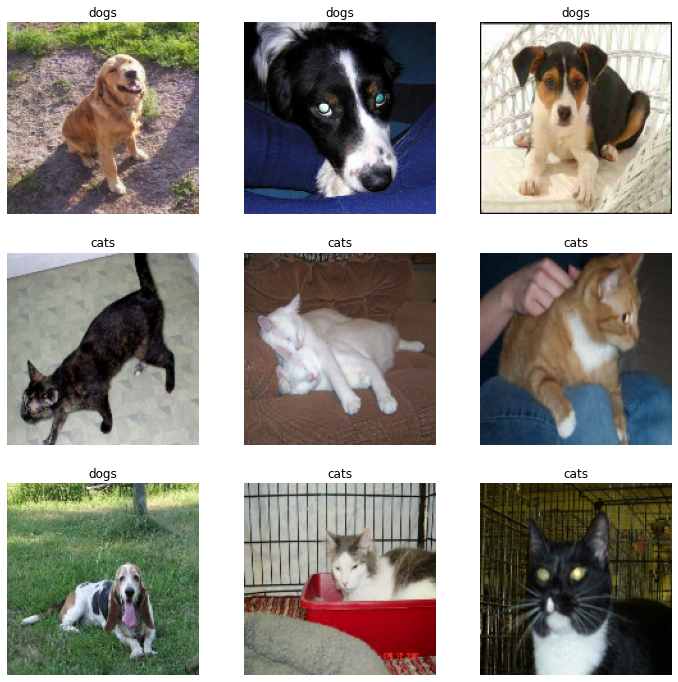

In [20]:
SOURCE_TRAIN = os.path.join('training_set', 'training_set')
SOURCE_TEST = os.path.join('test_set', 'test_set')
SOURCE = os.getcwd()
DogCatClassifier = InceptionClassifier(SOURCE, SOURCE_TRAIN, SOURCE_TEST)

In [21]:
DogCatClassifier.modelCompile(optimizer='adam',
                              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                              metrics=tf.keras.metrics.BinaryAccuracy(),
                              epochs=2
                              )


Epoch 1/2
251/251 [==============================] - 410s 2s/step - loss: 0.1457 - binary_accuracy: 0.9433 - val_loss: 0.0937 - val_binary_accuracy: 0.9614
Epoch 2/2
251/251 [==============================] - 402s 2s/step - loss: 0.0982 - binary_accuracy: 0.9650 - val_loss: 0.0887 - val_binary_accuracy: 0.9649


Training Accuracy: 97.66%, Validation Accuracy: 96.49%


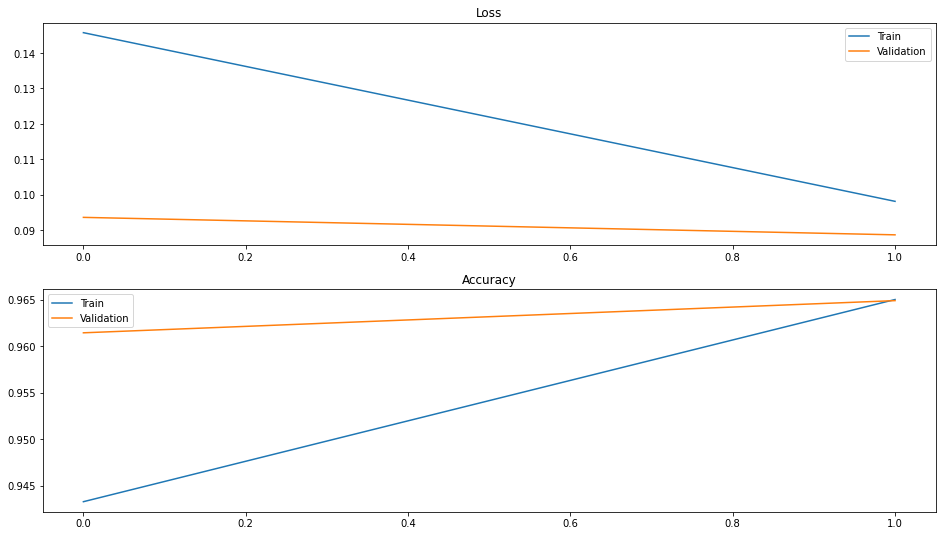

In [22]:
DogCatClassifier.modelEvaluate()